In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import textwrap
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
import seaborn as sns
from matplotlib import pyplot
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import math

#parameters for selecting data: type in the start date, the latest available date in the data is the end date
param_start_date='11/08/2016'
#if param_period is set as after, then selecting the time period after the param_start_date
#if param_period is set as before, then selecting the time period before the param_start_date for equal number of tweets as after the date
#if param_period is empty then selecting all the data
param_period=''

In [2]:
#read tweets and stock market data
name_tweets = "tweet_stock_results.json"

with open(name_tweets, "r") as file:
    tweets_dfxx = pd.read_json(file, orient='index')
print(tweets_dfxx.columns)

tweets_dfxx.sort_index(inplace=True)
tweets_dfxx = tweets_dfxx.reset_index(drop=True)

#keep only the tweet data and drop empty rows
tweets_dataframe=tweets_dfxx[tweets_dfxx["orig changes"].notnull()]

print("Number of tweets: ", len(tweets_dataframe))

if param_period=='':
    tweets_df=tweets_dataframe
else:

    #select the data sets based on the param_start_date
    tweets_dfa=tweets_dataframe.loc[tweets_dataframe["timestamp"] > datetime.strptime(param_start_date, '%m/%d/%Y')]
    print("Number of tweets after the start date: ", len(tweets_dfa))

    before=len(tweets_dataframe)-2*len(tweets_dfa)
    tweets_dfb=tweets_dataframe.loc[tweets_dataframe.index>before]
    tweets_dfb=tweets_dfb.loc[tweets_dfb["timestamp"] <= datetime.strptime(param_start_date, '%m/%d/%Y')]
    print("Number of tweets before the start date: ", len(tweets_dfb))

    if param_period=='after':
        tweets_df=tweets_dfa
    if param_period=='before':
        tweets_df=tweets_dfb    

Index(['daily change', 'date', 'difference', 'orig changes', 'orig stock',
       'predicted changes', 'prev stock', 'text', 'timestamp', 'tweet'],
      dtype='object')
Number of tweets:  1381


In [3]:
#partition of the data in six classes
tweets_dfbp=tweets_df.loc[tweets_df["orig changes"]=='BIGPOS']
print(len(tweets_dfbp))
tweets_dfbn=tweets_df.loc[tweets_df["orig changes"]=='BIGNEG']
print(len(tweets_dfbn))
tweets_dfmp=tweets_df.loc[tweets_df["orig changes"]=='MEDPOS']
print(len(tweets_dfmp))
tweets_dfmn=tweets_df.loc[tweets_df["orig changes"]=='MEDNEG']
print(len(tweets_dfmn))
tweets_dfsp=tweets_df.loc[tweets_df["orig changes"]=='SMAPOS']
print(len(tweets_dfsp))
tweets_dfsn=tweets_df.loc[tweets_df["orig changes"]=='SMANEG']
print(len(tweets_dfsn))

283
207
290
309
138
154


In [4]:
def most_common(data,number):
    most_common = Counter(" ".join(data["text"].dropna()).split()).most_common(number)
    print("Most common words: ", most_common)


def aggregate_tfidf(data,number):
    # Ignore too common terms (max_df = .25)
    v_data = TfidfVectorizer(max_df = .25)
    X_data = v_data.fit_transform(data["text"])

    X_mean= X_data.mean(axis=0)
    vec =[]
    for i in range(len(data)):
        vec.append(X_mean.item(i))

    data['tf_idf']=pd.Series(vec, index=data.index)
    #print(data.head())
    
    highest = [v_data.get_feature_names()[id] for id in (-X_data.mean(axis=0).A).argsort()[0][:number]]
    #print("Highest scores: ", highest)



In [5]:
#print most common x words
#most_common(tweets_dfbp,20)

#aggregate TF/IDF for sentence vector and print most common x words
aggregate_tfidf(tweets_dfbp,20)
aggregate_tfidf(tweets_dfbn,20)
aggregate_tfidf(tweets_dfmp,20)
aggregate_tfidf(tweets_dfmn,20)
aggregate_tfidf(tweets_dfsp,20)
aggregate_tfidf(tweets_dfsn,20)


C:\Users\Suvi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [6]:
tweets_dfb=tweets_dfbp.append(tweets_dfbn)
print(len(tweets_dfb))
tweets_dfm=tweets_dfmp.append(tweets_dfmn)
print(len(tweets_dfm))
tweets_dfs=tweets_dfsp.append(tweets_dfsn)
print(len(tweets_dfs))
tweets_dfbm=tweets_dfb.append(tweets_dfm)
print(len(tweets_dfbm))
tweets_dfbms=tweets_dfbm.append(tweets_dfs)
print(len(tweets_dfbms))
tweets_dfbms.sort_index(inplace=True)
print(tweets_dfbms.head())

490
599
292
1089
1381
      daily change       date  difference orig changes  orig stock  \
3885      113.3106 2015-06-15         0.0       MEDPOS  17791.1699   
3886      113.3106 2015-06-15         1.0       MEDPOS  17791.1699   
3887      113.3106 2015-06-15         1.0       MEDPOS  17791.1699   
3888       31.2597 2015-06-16         0.0       MEDPOS  17904.4805   
3889       31.2597 2015-06-16         1.0       MEDPOS  17904.4805   

     predicted changes  prev stock  \
3885            MEDNEG  17898.8398   
3886            MEDPOS  17898.8398   
3887            MEDPOS  17898.8398   
3888            MEDNEG  17791.1699   
3889            MEDPOS  17791.1699   

                                                   text           timestamp  \
3885  https https i d vote twice for you if i could ... 2015-06-15 11:30:53   
3886         tomorrow at am makeamericagreatagain https 2015-06-15 14:28:43   
3887                                       thanks https 2015-06-15 16:30:03   
3888  https 

In [7]:
#descriptive statistics


#stats for stock market data in predicted and original classes - not very informative
grouped_data = tweets_df.groupby(['orig changes']) #try adding 'predicted changes'
grouped_data['orig stock'].apply(mode, axis=None).reset_index()
descr = grouped_data['orig stock'].aggregate([np.median, np.std, np.mean, np.min, np.max]).reset_index()
descr

,orig changes,median,std,mean,amin,amax
0,BIGNEG,17910.33010,3565.195180,19706.576553,15871.3496,26743.5000
1,BIGPOS,17619.50980,3520.708994,19416.034615,15660.1797,26405.7598
2,MEDNEG,18223.02930,2956.903471,19907.156937,16014.3799,26562.0508
3,MEDPOS,18538.12015,3134.742799,20298.227451,15766.7402,26656.9805
4,SMANEG,18162.34960,2600.894231,19312.942647,16027.0498,26214.5996
5,SMAPOS,18128.66020,2750.987928,19809.453216,16351.3799,26145.9902


In [8]:
#stats for TF/IDF-scores in predicted and original classes 
grouped_data = tweets_dfbms.groupby(['orig changes']) #try adding 'predicted changes'
grouped_data['tf_idf'].apply(mode, axis=None).reset_index()
descr = grouped_data['tf_idf'].aggregate([np.median, np.std, np.mean, np.min, np.max]).reset_index()
descr

,orig changes,median,std,mean,amin,amax
0,BIGNEG,0.001574,0.003166,0.002812,0.000934,0.020716
1,BIGPOS,0.001145,0.003366,0.002285,0.000799,0.030849
2,MEDNEG,0.001014,0.003200,0.002101,0.000777,0.031185
3,MEDPOS,0.001148,0.002676,0.002120,0.000795,0.024046
4,SMANEG,0.002128,0.004762,0.003891,0.001442,0.035326
5,SMAPOS,0.002225,0.003680,0.003839,0.001588,0.022126


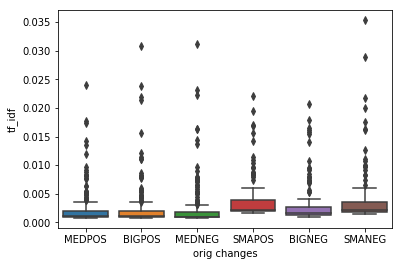

In [9]:
#distribution of TF/IDF scores within original stock market classes
sns.boxplot(x="orig changes", y="tf_idf", data=tweets_dfbms)

C:\Users\Suvi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


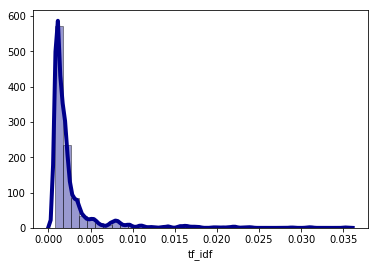

In [10]:
# Density Plot and Histogram of TF/IDF scores -not Gaussian
sns.distplot(tweets_dfbms['tf_idf'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

C:\Users\Suvi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


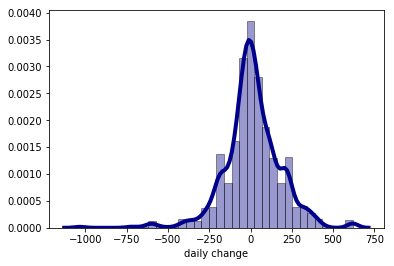

In [11]:
# Density Plot and Histogram of daily change -clearly Gaussian, normally distributed
sns.distplot(tweets_dfbms['daily change'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

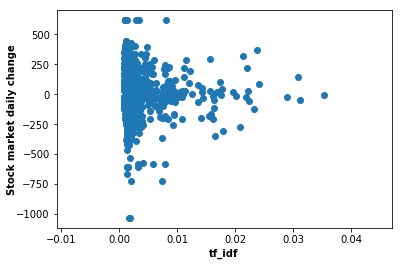

In [12]:
# plotting the data
pyplot.scatter(tweets_dfbms['tf_idf'],tweets_dfbms['daily change'])
pyplot.xlabel('tf_idf', fontweight='bold', color = 'black', fontsize='10', horizontalalignment='center')
pyplot.ylabel('Stock market daily change', fontweight='bold', color = 'black', fontsize='10', verticalalignment='center')
pyplot.show()

In [13]:
#Test of independency for two variables
#Spearman's and Kendall's Tau Correlation tests can be done also for non-normally distributed variables
#Pearson's correlation is reliable only for normally distributed variables
#if the p-value is much lower than 0.05, we reject the null hypothesis 
#and conclude that there is a statistically significant correlation

# calculate the correlation between two variables
def correlation_test(data1, data2, alpha):
    coef1, p_value1 = spearmanr(data1, data2)
    coef2, p_value2 = kendalltau(data1, data2)
    coef3, p_value3 = pearsonr(data1, data2)
    test=[['Spearmans correlation test',coef1,p_value1], ['Kendalltau correlation test',coef2,p_value2], 
          ['Pearsons correlation test',coef3,p_value3]]
    
    print("Test method                ", '\t', "Corr coefficient", '\t', "p-value", '\t', "Results")
    print("-----------------------------------------------------------------------------------------------")
    
    for value in test:
        #print(value[0], 'correlation coefficient: %.3f' % value[1])

        # interpret the significance
        if value[2] > alpha:
            #print('Samples are uncorrelated (fail to reject H0) p=%.3f' % value[2])
            result='Samples are uncorrelated'

        else:
            #print('Samples are correlated (reject H0) p=%.3f' % value[2])
            result='Samples are correlated'
        
        print(value[0] , '\t', "%.2f" % value[1], '         ', '\t', "%.3f" % value[2], '       ', '\t', result)
          

correlation_test(tweets_dfbms['tf_idf'],tweets_dfbms['daily change'], 0.05)  


Test method                 	 Corr coefficient 	 p-value 	 Results
-----------------------------------------------------------------------------------------------
Spearmans correlation test 	 -0.09           	 0.001         	 Samples are correlated
Kendalltau correlation test 	 -0.06           	 0.001         	 Samples are correlated
Pearsons correlation test 	 -0.04           	 0.145         	 Samples are uncorrelated


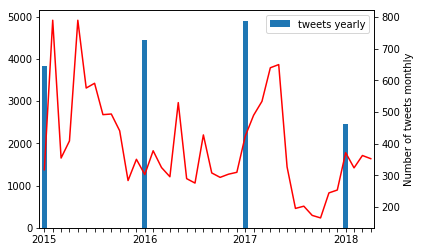

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

width = .6

m1_t = pd.DataFrame({
 'tweets yearly': [3829,0,0,0,0,0,0,0,0,0,0,0,4460,0,0,0,0,0,0,0,0,0,0,0,4905,0,0,0,0,0,0,0,0,0,0,0,2454,0,0,0],
 'tweets monthly': [318,790,355,409,790,576,591,492,494,441,284,351,303,378,
               325,296,530,290,276,428,308,294,304,310,424,490,534,640,650,
               327,196,203,174,166,245,254,372,324,363,353]})

m1_t[['tweets yearly']].plot(kind='bar', width = width)
m1_t['tweets monthly'].plot(color='red',secondary_y=True)
plt.ylabel('Number of tweets monthly')

ax = plt.gca()
plt.xlim([-width, len(m1_t['tweets yearly'])-width])
ax.set_xticklabels((2015,'','','','','','','','','','','',2016,'','','','','','','','','','','',2017,
                    '','','','','','','','','','','',2018,'','','')
)
plt.show()